## Data Visualizations

This file contains code to generate all of the visualizations that can be found in our presentation slides and/or readme file. 

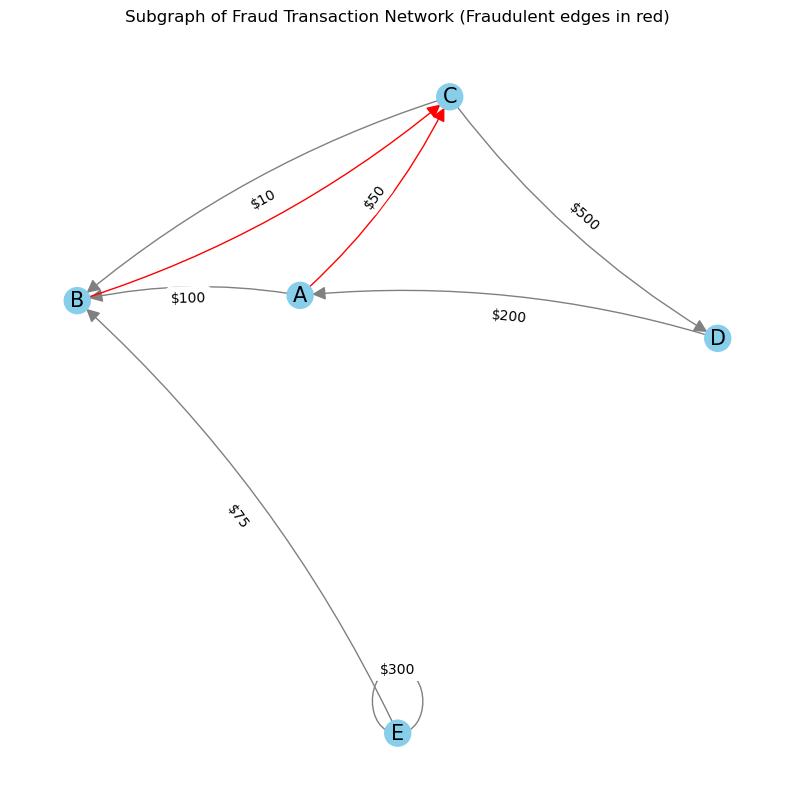

In [1]:
# This plot is meant to quickly convey the meaning of a "transaction network multidigraph". We can descibe this as an a simplified example of a subgraph of our entire transaction network graph.

import networkx as nx
import matplotlib.pyplot as plt

# instantiate multidigraph object
g = nx.MultiDiGraph()

# create accounts
accounts = ['A', 'B', 'C', 'D', 'E']

# add nodes from accounts
g.add_nodes_from(accounts)

# create transaction and add them as edges
g.add_edges_from([
        ('A', 'B', {'amount': '$100', 'Label': 'not fraud'}),
        ('A', 'C', {'amount': '$50', 'Label': 'fraud'}), # Fraudulent transaction
        ('B', 'C', {'amount': '$999', 'Label': 'fraud'}), # Fraudulent transaction
        ('C', 'D', {'amount': '$500', 'Label': 'not fraud'}),
        ('D', 'A', {'amount': '$200', 'Label': 'not fraud'}),
        ('E', 'B', {'amount': '$75', 'Label': 'not fraud'}),
        ('E', 'E', {'amount': '$300', 'Label': 'not fraud'}),
        ('C', 'B', {'amount': '$10', 'Label': 'not fraud' })
    ])

# 5. Prepare data for plotting
pos = nx.spring_layout(g, seed=831) # Set position for consistent layout
    
# Color nodes
node_colors = ['skyblue' for node in g.nodes()]

# Color edges: red for 'fraud', grey for 'legit'
edge_colors = []
for u, v, data in g.edges(data=True):
    if data.get('Label') == 'fraud':
        edge_colors.append('red')
    else:
        edge_colors.append('grey')

#Edge labels for transaction IDs
edge_labels = {(u, v): data['amount'] for u, v, data in g.edges(data=True)}

# 6. Plot the subgraph
plt.figure(figsize=(10, 10))
    
# Draw nodes
nx.draw_networkx_nodes(g, pos, node_color=node_colors, node_size=350)
    
# Draw edges with specific colors and curvature for multi-edges
nx.draw_networkx_edges(
        g, pos, 
        edge_color=edge_colors, 
        arrows=True, 
        arrowsize=20,
        connectionstyle='arc3,rad=0.1' # Adds curvature to distinguish parallel edges
    )

# Draw labels
nx.draw_networkx_labels(g, pos, font_size=15, font_color='black')
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_color='black' if 'red' in edge_colors else 'black')
    
plt.title("Subgraph of Fraud Transaction Network (Fraudulent edges in red)")
plt.axis('off')
plt.show()





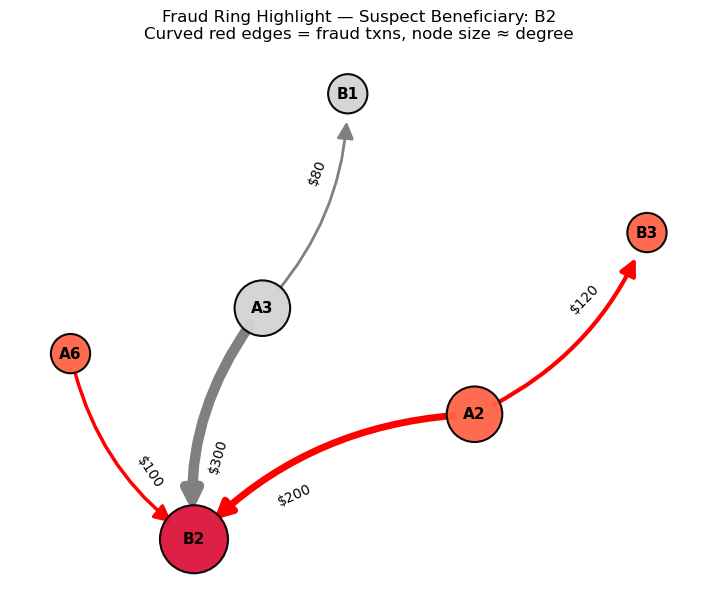

Suspected ring beneficiaries (>=2 unique fraud senders): ['B2']
  - B2: fraud senders ['A2', 'A6']


In [3]:
import pandas as pd
#Here is the code for the synthetic fraud ring figure:                                                                                                           #Synthetic stream (sender, bene, sender_country, bene_country, amount, label)
df = pd.DataFrame([
    ("A1","B1","US","US",150,0),
    # fraud B2
    ("A2","B2","UK","US",200,1),
    ("A3","B1","US","FR",80,0),
     # fraud B3 (same sender A2)
    ("A2","B3","UK","UK",120,1),
    ("A4","B4","US","US",500,0),
    ("A3","B2","US","US",300,0),
    ("A5","B3","CA","UK",50,0),
    # fraud B2 (another sender ring around B2)
    ("A6","B2","CA","US",100,1),
], columns=["Sender","Bene","Sender_Country","Bene_Country","USD_amount","Label"])
#MultiDiGraph + attach attributes following
G = nx.MultiDiGraph()
for _, r in df.iterrows():
    s, b = r["Sender"], r["Bene"]
    if not G.has_node(s): G.add_node(s, role="sender", country=r["Sender_Country"], fraud_touch=0)
    if not G.has_node(b): G.add_node(b, role="bene",   country=r["Bene_Country"], fraud_touch=0)
    # increment fraud exposure if this transaction is fraudulent
    G.nodes[s]["fraud_touch"] += r["Label"]
    G.nodes[b]["fraud_touch"] += r["Label"]
    G.add_edge(s, b, Label=r["Label"], amount=r["USD_amount"])
#Here is the  part where I build ring candidate beneficiaries:
#bene nodes with >=2 unique senders where Label==1 toward them
fraud_edges = [(u,v,d) for u,v,d in G.edges(data=True) if d.get("Label",0)==1]
bene_to_senders = {}
for u,v,d in fraud_edges:
    bene_to_senders.setdefault(v, set()).add(u)
ring_candidates = [bene for bene, senders in bene_to_senders.items() if len(senders) >= 2]
#If not found, then fall back to highest in degree bene
if not ring_candidates:
    bene_degrees = [(n, G.in_degree(n)) for n,attr in G.nodes(data=True) if attr.get("role")=="bene"]
    ring_candidates = [max(bene_degrees, key=lambda x:x[1])[0]] if bene_degrees else []
#take top candidate (here it's B2)
suspect_bene = ring_candidates[0]
#egosubgraph around the suspect beneficiary
#undirected for neighborhood extraction
H = nx.ego_graph(G.to_undirected(), suspect_bene, radius=2)
H_multi = G.subgraph(H.nodes()).copy()
plt.figure(figsize=(9,7))
pos = nx.spring_layout(H_multi, seed=42, k=1.2)
#Node styling
node_sizes = []
node_colors = []
node_labels = {}
for n,attr in H_multi.nodes(data=True):
    deg = H_multi.in_degree(n) + H_multi.out_degree(n)
    node_sizes.append(max(300, deg*800))
    if n == suspect_bene:
        node_colors.append("crimson")
    elif attr.get("fraud_touch",0) > 0:
        node_colors.append("tomato")
    else:
        node_colors.append("lightgray")
    node_labels[n] = n
nx.draw_networkx_nodes(H_multi, pos, node_size=node_sizes, node_color=node_colors,
                       edgecolors="black", linewidths=1.5, alpha=0.95)
#Edges with curvature for parallel arrows
nx.draw_networkx_edges(
    H_multi, pos,
    edge_color=["red" if d.get("Label",0)==1 else "gray" for u,v,d in H_multi.edges(data=True)],
    width=[max(1.0, d.get("amount",0)/40.0) for u,v,d in H_multi.edges(data=True)],
    arrows=True,
    arrowsize=25,
    connectionstyle='arc3,rad=0.2',   # <— slightly more curved
    min_source_margin=15,
    min_target_margin=20
)
#Labels for nodes
nx.draw_networkx_labels(H_multi, pos, labels=node_labels, font_size=11, font_weight="bold")
#Edge amount labels
edge_labels = {(u,v): f"${d.get('amount',0)}" for u,v,k,d in H_multi.edges(keys=True, data=True)}
nx.draw_networkx_edge_labels(
    H_multi, pos,
    edge_labels=edge_labels,
    font_size=10,
    font_color="black",
    label_pos=0.65
)
plt.title(f"Fraud Ring Highlight — Suspect Beneficiary: {suspect_bene}\n"
          "Curved red edges = fraud txns, node size ≈ degree")
plt.axis("off")
plt.show()
#Print summary
print("Suspected ring beneficiaries (>=2 unique fraud senders):", ring_candidates)
for bene in ring_candidates:
    print(f"  - {bene}: fraud senders {sorted(list(bene_to_senders[bene]))}")

In [4]:
# Visualize model performance on Fraud Losses
plt.bar(["Loss avoided", "Missed risk"], [loss_avoided, missed_risk], color=["#42A2B9", "crimson"])
plt.title("Model Performance on Fraud Losses")
plt.ylabel("USD (Millions)")
plt.show()

NameError: name 'loss_avoided' is not defined

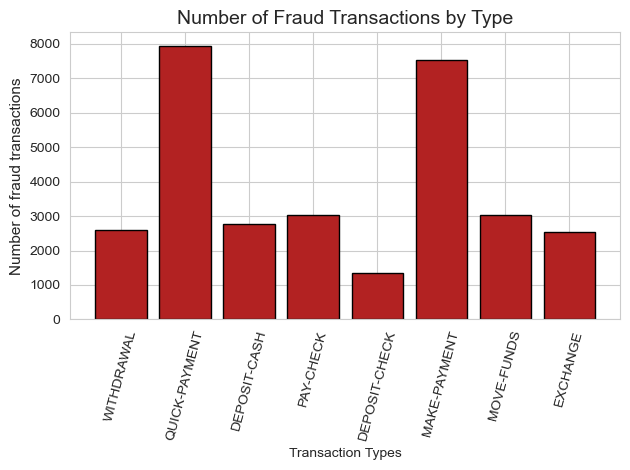

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time

sns.set_style("whitegrid")
blue, = sns.color_palette("muted", 1)
# Loads full dataset
JPfraud_full = pd.read_csv('/Users/brandonowens/Downloads/Fraud_Payments 2/data/fraud_payment_data')
JPfraud_full
# Removing $0 transactions, which contain no fraud labels
JPfraud = JPfraud_full[JPfraud_full.USD_amount > 0].reset_index(level=0,drop=True)

# Gathering the number of fraud and non-fraud transactions for each transaction type
trans_types = JPfraud.Transaction_Type.unique()
fraud_number = np.zeros(len(trans_types))
non_fraud_number = np.zeros(len(trans_types))

for i, trans in enumerate(trans_types):
    fraud_number[i] = JPfraud.loc[JPfraud.Transaction_Type == trans].Label.sum()
    non_fraud_number[i] = len(JPfraud[JPfraud.Label == 0].loc[JPfraud.Transaction_Type == trans])
plt.figure()

plt.bar(trans_types, fraud_number, edgecolor='black', color='firebrick')
plt.xlabel('Transaction Types',fontsize=10)
plt.ylabel('Number of fraud transactions',fontsize=11)
plt.xticks(np.arange(len(trans_types)),trans_types,rotation=75)
plt.title('Number of Fraud Transactions by Type',fontsize=14)
plt.tight_layout()
plt.savefig('Fraud_number_vs_transaction_types.png')
plt.show()




OSError: [Errno 30] Read-only file system: 'fraud_and_non-fraud_vs_transaction_types.png'

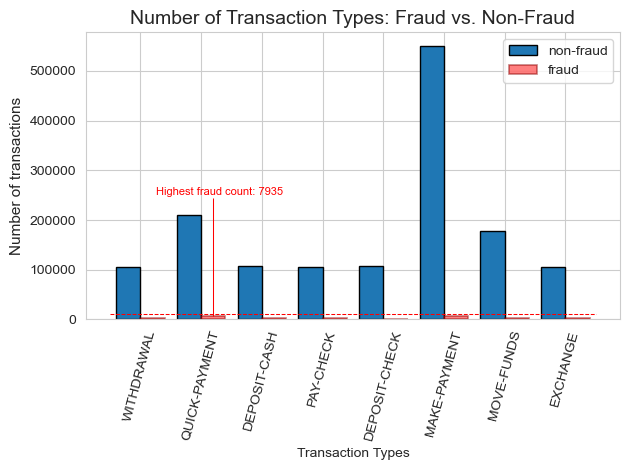

In [7]:
plt.figure()

w = 0.4

plt.bar(np.arange(len(trans_types))-w/2, non_fraud_number, label='non-fraud', edgecolor='black', width=w)
plt.bar(np.arange(len(trans_types))+w/2, fraud_number, alpha = 0.5, color='red', width=w,
        label='fraud', edgecolor='darkred', linewidth=1.2)
plt.hlines(y=fraud_number[1]+2038, xmin=-0.5, xmax=len(trans_types)-0.5,
           linewidth=0.75, color='red', linestyle='--')
plt.vlines(x=1.2, ymin=fraud_number[1], ymax=245000,
           linewidth=0.75, color='red', linestyle='-')
plt.text(0.25,250000, 'Highest fraud count: 7935', fontsize=8, color='red')
plt.xlabel('Transaction Types',fontsize=10)
plt.ylabel('Number of transactions',fontsize=11)
plt.xticks(np.arange(len(trans_types)), trans_types, rotation=75)
plt.title('Number of Transaction Types: Fraud vs. Non-Fraud',fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('fraud_and_non-fraud_vs_transaction_types.png')
plt.show()

Heads up - the following cell took my computer over 2hrs to run.

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0, 0.5, 'Lift')

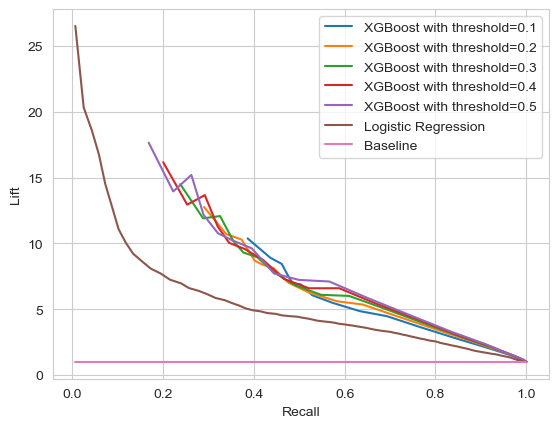

In [3]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

total_data = pd.read_csv('/Users/brandonowens/Downloads/Fraud_Payments 2/data/fraud_payment_data', sep=',', header=0)
final_features = pd.read_csv('/Users/brandonowens/Downloads/total_features', sep = ',', header=0)
total_data=total_data[total_data.USD_amount>0]
total_data=total_data.reset_index(drop=True)
##Split for train, validate and test data
train_features=final_features[0:1000000]
validate_features=final_features[1000000:1250000]
test_features=final_features[1250000:-1]
y_train=total_data['Label'][0:1000000]
y_validate=total_data['Label'][1000000:1250000]
y_test=total_data['Label'][1250000:-1]
##Scaler for eventual Logistic regression
X=StandardScaler().fit_transform(train_features.values)
#Initialize the models:
log_reg = LogisticRegression(class_weight='balanced', penalty=None)
xgb=XGBClassifier(learning_rate= 0.01, max_depth= 70, n_estimators= 700, scale_pos_weight = 50)
xgb.fit(X,y_train)
log_reg.fit(X,y_train)
#Now plot the visualizations with the code below:
#Run the visuals:
##Generate Recall-Lift graph for logistic regression (balancing for the class imbalance). Variable recall is obtained by varying the cutoff.
lift_scores=np.zeros(100)
recall_scores=np.zeros(100)
log_reg = LogisticRegression(class_weight='balanced', penalty=None)
log_reg.fit(X,y_train)
y_prob = log_reg.predict_proba(StandardScaler().fit_transform(test_features.values))[:,1]
for i in range(100):
    y_pred = 1*(y_prob >= i/100)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    ppr=(tp+fp)/(tn+fp+fn+tp)
    lift=recall/ppr
    recall_scores[i]=recall
    lift_scores[i]=lift
##Generate Recall-Lift graph for optimized XGBoost models with different cutoffs (balancing for the class imbalance).
##Variable recall is obtained by varying the weight of the class.
for j in range(5):
  lift_scores2=np.zeros(20)
  recall_scores2=np.zeros(20)
  for i in range(20):
    xgb=XGBClassifier(learning_rate= 0.01, max_depth= 70, n_estimators= 700, scale_pos_weight = 4**i)
    xgb.fit(X,y_train)
    y_prob=xgb.predict_proba(StandardScaler().fit_transform(test_features.values))[:,1]
    y_pred = 1*(y_prob >= (j+1)/10)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    ppr=(tp+fp)/(tn+fp+fn+tp)
    lift=recall/ppr
    recall_scores2[i]=recall
    lift_scores2[i]=lift
    print(i)
  plt.plot(recall_scores2, lift_scores2,label=('XGBoost with threshold='+str((j+1)/10)))
plt.plot(recall_scores, lift_scores,label='Logistic Regression')
plt.plot(recall_scores, np.ones(len(recall_scores)),label='Baseline')
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Lift")